In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import trackpy as tp
import pims
import matplotlib as mpl

In [2]:
def calculateNoise(I):
    '''
    #regular inline code      threshold = noisecalculator(I);
    #regular function code    function [ threshold ] = noisecalculator( I )
    # now comes the noisecalculator
    # This function calculates the amount of noise in an image. The returned
    # value 'noiseI' is the noise intensity which should be removed from all
    # images in a .tif file.
    # It's probably sufficient to run this function once for every .tif file,
    # since approximately all images in the file contain the same amount of
    # noise. This will reduce the calculation time drastically. '''
        
    # Delete background intensity
    In = I.flatten()           # Most Python functions don't work for a 2D array, so In has to be flattened.
    Im = np.sort(In)  # A sorted list of I, with background intensity. 
    if show == 1:   
        plt.figure()
        plt.title('Sorted intensity values')
        plt.xlabel('x')   
        plt.ylabel('y')   
        plt.grid()
        plt.plot(Im)                # In this plot it can be seen that Im has been correctly sorted. 
    med = np.median(Im)         # The median of IM can be calculated from the flattened sorted array Im.       
    Imed = abs(I - med)


    # Calculate the noise intensity
    ilst = np.sort(Imed)                    # To create a sorted list of all present intensities.
    ilstflat = np.sort(ilst.flatten())      # ilst has to be flattened to find the max value with Python.
    ilst_t = ilst.transpose()       
    ilstflat_t = np.sort(ilst_t.flatten())  # With the normal flatten function the rows are put bewelow eacht other, but we want to put the columns next to each other. Thus the transposed version of ilst is needed.
    b = len(Im)
    x = np.arange(1,b+1)
    Ihalf = (max(In)-med)/2
    # Ihalf=max(ilstflat)/2

    # Make sure that the flattened ilst is also sorted, otherwise the wrong index is found.
    xIhalf_value = list(filter(lambda i: i > Ihalf, ilstflat_t))[0]         # This function gives the first value where ilst > Ihalf. With this value it can be checked if the position calculated in the next line is correct.
    xIhalf = next(x for x, val in enumerate(ilstflat_t)
                                      if val > Ihalf)                           # Here the position of the first index with a value bigger than Ihalf is found.
    range_up=int(np.floor(b/2))
    coeff1= np.polyfit(x[0:range_up], ilstflat_t[0:range_up],1)      
    coeff2 = np.polyfit(x[int(xIhalf):b], ilstflat_t[int(xIhalf):b], 1)     # Makes a linear fit to the highest half of all intensities in 'ilist'. 
    if show:
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Noise intensity')
        plt.grid()
        plt.plot(x,np.sort(ilstflat_t),'b-')    

    # The rightmost intersection is the chosen noise intensity which will be removed from all images.
    fit1 = np.polyval(coeff1,x)                                     # Returns an array of all values of the fitted line for every x coordinate.
    fit2 = np.polyval(coeff2,x)                                         
    xcross=round((coeff1[1]-coeff2[1])/(coeff2[0]-coeff1[0]))
    ycross= np.polyval(coeff1,xcross)
    fit=np.concatenate([fit1[0:int(xcross-1)],fit2[int(xcross-1):]])
    if show:
        plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'r'), plt.ylim([0,max(ilstflat)])
    scale=max(x)/max(ilstflat)
    dist=np.sqrt((x-xcross)**2+(ycross-ilstflat_t*scale)**2)        # Calculates the difference between the true intensities and the values of crossing fitted lines.
    xmindist = next(x for x, val in enumerate(dist) 
                                  if val == min(dist))              # Calculates the x value of the rightmost intersection of the fitted line and the curve of all true intensities.
    threshold=ilstflat_t[(xmindist-1)]+np.std(ilst)                 # Calculates the intensity, which belongs to the above calculated x value. This equals the intensity of the noise which should be delete.
    if show:
        plt.plot(x,np.sort(ilstflat_t),'b-', x,fit,'k', xcross,ycross,'kx', xmindist, ilstflat_t[xmindist],'mo', [0,max(x)],[threshold,threshold],'r')     
    return threshold

In [4]:
show=0   # show = 0 -> don't show filtering plots, show = 1 --> show filtering plots

fileloc = r'C:\Users\vanlo\Documents\GitHub\Tweezer\Python\trap 20 mW_0.tif'
frames = pims.open(fileloc)     # import file
threshold = calculateNoise(frames[0])   # Calculate noise threshold of first frame
f = tp.batch(frames,15, minmass = 100, maxsize=10, threshold=threshold, topn=1)    # Find bead location for all frames
X = f['x']
Y = f['y']

Frame 999: 1 features


<IPython.core.display.Javascript object>


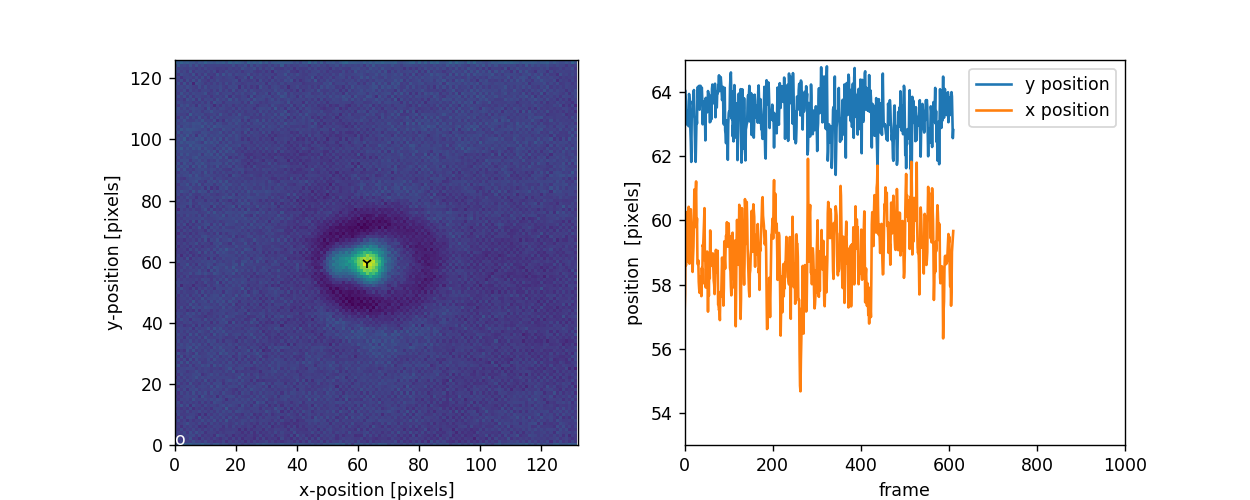

In [14]:
### Plotting result

%matplotlib notebook

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
line, = ax[0].plot(0, 0, marker="1", color="black")
txt = ax[0].text(0,0,'o', color='white')
ani_im = ax[0].imshow(frames[0], origin='lower')

ax[0].set_ylim(0,np.shape(frames)[1])
ax[0].set_xlim(0,np.shape(frames)[2])
ax[0].set_xlabel('x-position [pixels]')
ax[0].set_ylabel('y-position [pixels]')

linex, = ax[1].plot(0,0, label='y position')
liney, = ax[1].plot(0,0, label='x position')


ax[1].set_xlim(0,np.shape(frames)[0])
ax[1].set_ylim(int(np.min((X,Y))-1), int(np.max((X,Y)))+1)

ax[1].set_xlabel('frame')
ax[1].set_ylabel('position  [pixels]')
ax[1].legend()

def animation_frame(iterant):
    ani_im.set_array(frames[iterant])

    #fig.set_title(str(iterant))

    line.set_xdata(X[iterant])
    line.set_ydata(Y[iterant])
#     txt.set_position((Yest[iterant],Xest[iterant]+10))
#     txt.set_text( ( str(Xest[iterant])[0:3],str(Yest[iterant])[0:3] ) )
#     txt.set_color(color[iterant])

    linex.set_xdata(np.arange(iterant))
    liney.set_xdata(np.arange(iterant))
    linex.set_ydata(X[0:iterant])
    liney.set_ydata(Y[0:iterant])
    return [line,linex,liney]

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(np.shape(frames)[0]), interval=10)
plt.show()


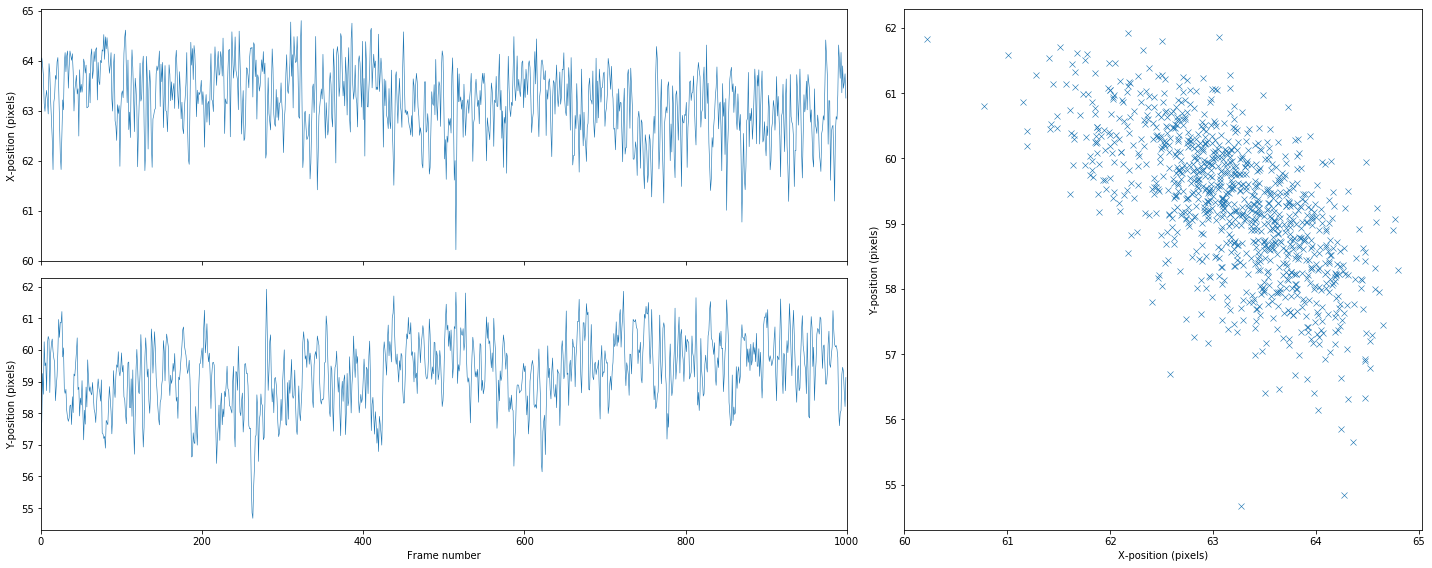

In [47]:
%matplotlib inline
# Set up the axes with gridspec
fig = plt.figure(figsize=(20, 8))
grid = plt.GridSpec(4, 10, hspace=0.2, wspace=0.2, )
spread = fig.add_subplot(grid[:, 6:])
Y_plot = fig.add_subplot(grid[2:, :6])
X_plot = fig.add_subplot(grid[:2, :6], xticklabels=[])

# scatter points on the main axes
spread.plot(X, Y, marker='x', linestyle='none', mew=0.6)
spread.set_xlabel('X-position (pixels)')
spread.set_ylabel('Y-position (pixels)')
# Plot Y and X position

Y_plot.plot(Y, linewidth=0.6)
X_plot.plot(X, linewidth=0.6)
X_plot.set_ylabel('X-position (pixels)')
Y_plot.set_ylabel('Y-position (pixels)')
Y_plot.set_xlabel('Frame number')
X_plot.set_xlim(0,1000)
Y_plot.set_xlim(0,1000)
grid.tight_layout(fig)


